스케쥴러 변경
기존
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


변경
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [1]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
root_dir = './datasets/dogs'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [4]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=1)[1]] = i

In [5]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [6]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        self.annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [7]:
transformer = A.Compose([
    A.Resize(224,224),
    A.OneOf([
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
    ], p=1),
    A.Normalize(),
    ToTensorV2()
])

In [8]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [9]:
total_label = [data['label'] for data in total_dataset]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

In [10]:
train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [11]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

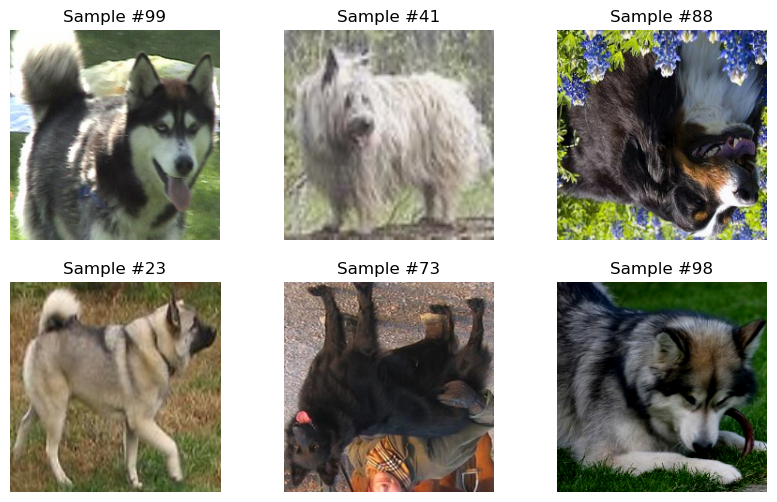

In [12]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [13]:
batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [14]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([32, 3, 224, 224]), 32)

# 모델 생성

In [15]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 모델 변경

In [17]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [18]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [19]:
for parameter in model.fc.parameters():
    parameter.requires_grad=True

In [20]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [21]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
out = model(batch['image'].to(device))
out.shape

torch.Size([32, 120])

In [23]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [24]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [25]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [26]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 10
    save_loss = np.inf

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(trainloader):
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                if (valid_loss < save_loss) and (valid_accuracy >= max_accuracy):
                    save_loss = valid_loss
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'D:/coding/models/dogs/best_ckpt_transfer_res101_batch32_half.pth')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')
                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)


In [27]:
epochs = 150
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:26<00:00,  4.79it/s]

Epoch : 1/150....... Train Loss : 2.425 Valid Loss : 1.371 Valid Accuracy : 0.695
save ckpt


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:26<00:00,  4.75it/s]

Epoch : 2/150....... Train Loss : 1.134 Valid Loss : 1.096 Valid Accuracy : 0.725
save ckpt


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:25<00:00,  4.84it/s]

Epoch : 3/150....... Train Loss : 0.867 Valid Loss : 1.006 Valid Accuracy : 0.732
save ckpt


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:25<00:00,  4.76it/s]

Epoch : 4/150....... Train Loss : 0.755 Valid Loss : 0.979 Valid Accuracy : 0.739
save ckpt


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:25<00:00,  4.82it/s]

Epoch : 5/150....... Train Loss : 0.656 Valid Loss : 0.967 Valid Accuracy : 0.739
save ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:46<00:00,  3.86it/s]


Epoch : 6/150....... Train Loss : 0.592 Valid Loss : 0.942 Valid Accuracy : 0.738


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:25<00:00,  4.81it/s]

Epoch : 7/150....... Train Loss : 0.531 Valid Loss : 0.903 Valid Accuracy : 0.752
save ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:46<00:00,  3.87it/s]


Epoch : 8/150....... Train Loss : 0.473 Valid Loss : 0.912 Valid Accuracy : 0.749
----trigger---- 1


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:47<00:00,  3.85it/s]


Epoch : 9/150....... Train Loss : 0.448 Valid Loss : 0.904 Valid Accuracy : 0.748
----trigger---- 2


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:49<00:00,  3.76it/s]


Epoch : 10/150....... Train Loss : 0.409 Valid Loss : 0.918 Valid Accuracy : 0.746
----trigger---- 3


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:48<00:00,  3.78it/s]


Epoch : 11/150....... Train Loss : 0.383 Valid Loss : 0.946 Valid Accuracy : 0.742
----trigger---- 4
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.31it/s]


Epoch : 12/150....... Train Loss : 0.320 Valid Loss : 0.932 Valid Accuracy : 0.751
----trigger---- 5


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:40<00:00,  4.17it/s]

Epoch : 13/150....... Train Loss : 0.314 Valid Loss : 0.888 Valid Accuracy : 0.754
save ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:05<00:00,  3.27it/s]


Epoch : 14/150....... Train Loss : 0.288 Valid Loss : 0.885 Valid Accuracy : 0.751


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:05<00:00,  3.27it/s]


Epoch : 15/150....... Train Loss : 0.276 Valid Loss : 0.913 Valid Accuracy : 0.754
----trigger---- 1


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:06<00:00,  3.27it/s]


Epoch : 16/150....... Train Loss : 0.264 Valid Loss : 0.896 Valid Accuracy : 0.753
----trigger---- 2


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.30it/s]


Epoch : 17/150....... Train Loss : 0.258 Valid Loss : 0.902 Valid Accuracy : 0.751
----trigger---- 3


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.30it/s]


Epoch : 18/150....... Train Loss : 0.248 Valid Loss : 0.912 Valid Accuracy : 0.751
----trigger---- 4
Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [01:40<00:00,  3.98it/s]

Epoch : 19/150....... Train Loss : 0.225 Valid Loss : 0.839 Valid Accuracy : 0.764
save ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:05<00:00,  3.27it/s]


Epoch : 20/150....... Train Loss : 0.212 Valid Loss : 0.898 Valid Accuracy : 0.752
----trigger---- 1


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:53<00:00,  3.62it/s]


Epoch : 21/150....... Train Loss : 0.212 Valid Loss : 0.875 Valid Accuracy : 0.755
----trigger---- 2


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [01:59<00:00,  3.46it/s]


Epoch : 22/150....... Train Loss : 0.206 Valid Loss : 0.917 Valid Accuracy : 0.752
----trigger---- 3


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:05<00:00,  3.29it/s]


Epoch : 23/150....... Train Loss : 0.201 Valid Loss : 0.849 Valid Accuracy : 0.765
----trigger---- 4
Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.32it/s]


Epoch : 24/150....... Train Loss : 0.193 Valid Loss : 0.932 Valid Accuracy : 0.744
----trigger---- 5


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:05<00:00,  3.28it/s]


Epoch : 25/150....... Train Loss : 0.189 Valid Loss : 0.853 Valid Accuracy : 0.766
----trigger---- 6


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.30it/s]


Epoch : 26/150....... Train Loss : 0.193 Valid Loss : 0.894 Valid Accuracy : 0.753
----trigger---- 7


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.31it/s]


Epoch : 27/150....... Train Loss : 0.188 Valid Loss : 0.854 Valid Accuracy : 0.770
----trigger---- 8
Epoch 00027: reducing learning rate of group 0 to 6.2500e-05.


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:05<00:00,  3.29it/s]


Epoch : 28/150....... Train Loss : 0.173 Valid Loss : 0.875 Valid Accuracy : 0.753
----trigger---- 9


100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [02:04<00:00,  3.32it/s]


Epoch : 29/150....... Train Loss : 0.180 Valid Loss : 0.865 Valid Accuracy : 0.763
----trigger---- 10


100%|███████████████████████████████████████████████████████████████████████████████▊| 411/412 [02:04<00:00,  3.29it/s]

Epoch : 30/150....... Train Loss : 0.171 Valid Loss : 0.849 Valid Accuracy : 0.763
----trigger---- 11
Early Stopping
training loop is finished


NameError: name 'writer' is not defined

# 모델 예측

In [39]:
test_iter = iter(testloader)

batch = next(test_iter)

images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 224, 224]) tensor(3, device='cuda:0')


In [40]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([True], device='cuda:0')


pred: tensor([3], device='cuda:0') labels: tensor(3, device='cuda:0')
torch.Size([224, 224, 3])


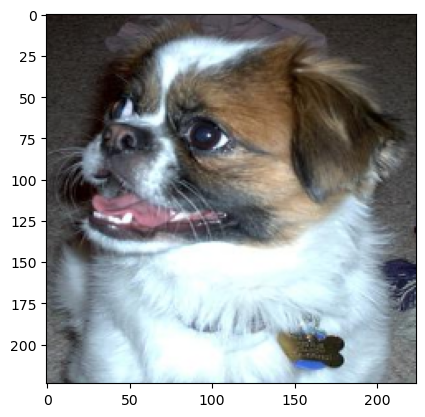

In [41]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [42]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in tqdm(testloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:26<00:00,  4.78it/s]

Test Loss : 0.828 Test Accuracy : 0.762


# 모델 저장

In [43]:
torch.save(model.state_dict(), 'D:/coding/models/dogs/last_ckpt_transfer_res101_batch32_half.pth')

In [44]:
last_state_dict = torch.load('D:/coding/models/dogs/last_ckpt_transfer_res101_batch32_half.pth')

In [45]:
last_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
last_model.fc = nn.Linear(in_features=2048, out_features=120)
last_model.to(device)
last_model.get_parameter = last_model.load_state_dict(last_state_dict)

In [46]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:26<00:00,  4.81it/s]

Test Loss : 0.857 Test Accuracy : 0.762


In [47]:
best_state_dict = torch.load('D:/coding/models/dogs/best_ckpt_transfer_res101_batch32_half.pth')

In [48]:
best_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
best_model.fc = nn.Linear(in_features=2048, out_features=120)
best_model.to(device)
best_model.get_parameter = best_model.load_state_dict(best_state_dict)

In [49]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:26<00:00,  4.88it/s]

Test Loss : 0.843 Test Accuracy : 0.763
